# Approach

1. > compare Embeddings (```minorminer```) and choose the best
1. > compare Chain Settings and choose the best
1. > compare Anneal Times and choose the best
1. > compare Anneal Schedules and choose the best

## QUBO

### Imports

In [1]:
import sys
sys.path.append("..")
from qubo_util import *

import dimod
import numpy as np
import pandas as pd
import dwave.inspector
import matplotlib.pyplot as plt
from dwave.system.samplers import DWaveSampler
from dwave.embedding.chain_strength import scaled, uniform_torque_compensation
from dwave.system import DWaveSampler, FixedEmbeddingComposite, EmbeddingComposite

### Config

In [2]:
from dwave.cloud import Client
client = Client.from_config(config_file='/Users/jonas/Library/Application Support/dwave/dwave.conf')

### Jobs

In [3]:
### Lets define the basics

bend = [0, 1, 2]
weld = [3, 4]
paint =  [5]

bend_length = 2
weld_length = 3
paint_length = 6

t_step = 3
t_step_in_sec = 30

In [4]:
jobs = [(0, 0, 4, 3, 6, 9),
 (1, 0, 2, 6, 0, 4)]

In [5]:
# OrderNo, PartNo, BendingLines, WeldingPoints, PaintTime, DueDate 

m_t_steps = max_time(jobs, bend_length, weld_length, paint_length)

m_time = m_t_steps * t_step_in_sec
    
print('The maximal maketime for the given operations is: ' + str(m_time) + ' second(s).\nWhich is equal to: ' + str(m_t_steps) + ' time steps.\n\n')

The maximal maketime for the given operations is: 1980 second(s).
Which is equal to: 66 time steps.




In [6]:
operations = ops(jobs, bend, weld, paint, bend_length, weld_length, paint_length, t_step)

print('Anzahl an Kombinationen: ' + str(len(operations)) + '\n')

Anzahl an Kombinationen: 105



### Parameters

In [7]:
alpha = 2
beta = 1.5
gamma = 2
delta = 0.035

QUBO = get_QUBO(jobs, operations, alpha, beta, gamma, delta, bend_length, weld_length, paint_length, bend, weld, paint)
qubo_dictionary = qubo_to_dictionary_ohne_null(QUBO, operations)


# Run

## Get Embedding with ```  minorminer  ``` as part of EmbeddingComposite() and safe it

https://docs.dwavesys.com/docs/latest/handbook_embedding.html#example-clique-embedding-a-sparse-bqm

https://docs.dwavesys.com/docs/latest/handbook_qpu.html?highlight=sampleset_1#read-anneal-cycles

In [8]:
bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(QUBO)
qpu = DWaveSampler(solver={'topology__type': 'pegasus'})

In [9]:
# Each run with 500 shots (more runs with less shots yield better results than less runs with more shots)
numr = 500

# Chain Strength = Max(QUBO) // Analog zur D Wave Dokumentation

chnstr = find_chstr(QUBO)+1

# Empty array
data=[]

### And Visualize embedding,  check for Chain Breaks and run inspection with ```dwave.inspector.```

#### First Embedding

In [10]:
sampler = EmbeddingComposite(qpu)
sampleset1A = sampler.sample(bqm, 
                           return_embedding=True, 
                           answer_mode="raw", 
                           num_reads=numr, 
                           chain_strength= chnstr)
embedding1 = sampleset1A.info["embedding_context"]["embedding"]  
chains = sampleset1A.info["embedding_context"]["embedding"].values()  

In [11]:
analyze(sampleset1A, "embedding1A", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [9.065]
Average energy is 58.35 with standard deviation 22.88


In [12]:
sampleset1B = FixedEmbeddingComposite(qpu, embedding1).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)

In [13]:
analyze(sampleset1B, "embedding1B", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [4.425000000000001]
Average energy is 55.86 with standard deviation 22.65


In [14]:
print(sampleset1A.info["embedding_context"]["chain_strength"])    

9.0


In [15]:
print(max(len(chain) for chain in chains))   

16


In [16]:
print("Percentage of samples with >10% breaks is {} and >0 is {}.".format(np.count_nonzero(sampleset1A.record.chain_break_fraction > 0.10)/numr*100, np.count_nonzero(sampleset1A.record.chain_break_fraction > 0.0)/numr*100))


Percentage of samples with >10% breaks is 100.0 and >0 is 100.0.


In [ ]:
# Inspect Embedding
dwave.inspector.show(sampleset1A)

#### Second Embedding

In [17]:
sampler = EmbeddingComposite(qpu)
sampleset2A = sampler.sample(bqm, 
                           return_embedding=True, 
                           answer_mode="raw", 
                           num_reads=numr, 
                           chain_strength= chnstr)
embedding2 = sampleset2A.info["embedding_context"]["embedding"]  
chains = sampleset2A.info["embedding_context"]["embedding"].values()  


In [18]:
analyze(sampleset2A, "embedding2A", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [5.365]
Average energy is 94.13 with standard deviation 36.46


In [19]:
sampleset2B = FixedEmbeddingComposite(qpu, embedding2).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)

In [20]:
analyze(sampleset2B, "embedding2B", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [6.76]
Average energy is 83.82 with standard deviation 38.14


In [21]:

print(sampleset2A.info["embedding_context"]["chain_strength"])    

9.0


In [22]:
print(max(len(chain) for chain in chains))   

17


In [23]:
print("Percentage of samples with >10% breaks is {} and >0 is {}.".format(np.count_nonzero(sampleset2A.record.chain_break_fraction > 0.10)/numr*100, np.count_nonzero(sampleset2A.record.chain_break_fraction > 0.0)/numr*100))


Percentage of samples with >10% breaks is 100.0 and >0 is 100.0.


In [ ]:
# Inspect Embedding
dwave.inspector.show(sampleset2A) 

#### Third Embedding

In [24]:
sampler = EmbeddingComposite(qpu)
sampleset3A = sampler.sample(bqm, 
                           return_embedding=True, 
                           answer_mode="raw", 
                           num_reads=numr, 
                           chain_strength= chnstr)
embedding3 = sampleset3A.info["embedding_context"]["embedding"]  
chains = sampleset3A.info["embedding_context"]["embedding"].values()  


In [25]:
analyze(sampleset3A, "embedding3A", data)

Good solutions are 0.6% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-5.7]
Average energy is 18.46 with standard deviation 14.69


In [26]:
sampleset3B = FixedEmbeddingComposite(qpu, embedding3).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)

In [27]:
analyze(sampleset3B, "embedding3B", data)

Good solutions are 1.0% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-4.935]
Average energy is 18.62 with standard deviation 14.30


In [28]:

print(sampleset3A.info["embedding_context"]["chain_strength"])    

9.0


In [29]:
print(max(len(chain) for chain in chains))   

13


In [30]:
print("Percentage of samples with >10% breaks is {} and >0 is {}.".format(np.count_nonzero(sampleset3A.record.chain_break_fraction > 0.10)/numr*100, np.count_nonzero(sampleset3A.record.chain_break_fraction > 0.0)/numr*100))


Percentage of samples with >10% breaks is 100.0 and >0 is 100.0.


In [31]:
# Inspect Embedding
dwave.inspector.show(sampleset3A) 

'http://127.0.0.1:18000/?problemId=c9047a1d-bc0d-4016-9e55-c8e0739b8ab9'

## Chain Management for best Embedding

In [32]:
# Choose best Embedding 
embedding = embedding3

### Adjust Chain Strength if necessary 

The following considerations and recommendations apply to chains.

- Prefer short chains to long chains.
- Prefer uniform chain lengths to uneven chains.
- Balance chain strength and problem range. Estimate chain strength and set just slightly above the minimum threshold needed, using strategies for auto-adjusting these chains. 

##### run again with each chain setting

In [33]:
# Default
sampleset_default = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)


In [34]:
analyze(sampleset_default, "default_chains", data)

Good solutions are 0.4% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-6.504999999999999]
Average energy is 15.48 with standard deviation 13.53


You can set a chain strength relative to your problem’s largest bias by using, for example, the scaled() function.

In [35]:
chnstr = scaled

In [36]:
#from dwave.embedding.chain_strength import scaled
sampleset_scaled1 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)  


In [37]:
analyze(sampleset_scaled1, "scaled_chains1", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [314.45]
Average energy is 647.87 with standard deviation 147.82


In [38]:
#from dwave.embedding.chain_strength import scaled
sampleset_scaled2 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)  


In [39]:
analyze(sampleset_scaled2, "scaled_chains2", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [180.535]
Average energy is 618.38 with standard deviation 153.67


Chain strength that attempts to compensate for torque that would break the chain.

In [40]:
chnstr = uniform_torque_compensation

In [41]:
#from dwave.embedding.chain_strength import uniform_torque_compensation
sampleset_torque1 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)  


In [42]:
analyze(sampleset_torque1, "torque_chains1", data)

Good solutions are 0.4% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [2.7750000000000004]
Average energy is 48.25 with standard deviation 27.71


In [43]:
#from dwave.embedding.chain_strength import uniform_torque_compensation
sampleset_torque2 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)  


In [44]:
analyze(sampleset_torque2, "torque_chains2", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-4.54]
Average energy is 50.74 with standard deviation 28.55


## Run for different Times and Schedules

In [45]:
# With optimal chain strengths:
chnstr = uniform_torque_compensation

https://docs.dwavesys.com/docs/latest/handbook_qpu.html?highlight=anneal_schedule#annealing-schedule

https://docs.dwavesys.com/docs/latest/c_qpu_0.html?highlight=quench

In [46]:
#qpu.properties["default_annealing_time"]      
# 20

### Find Sweet Spot for Annealing Time

In [47]:
#20
sampleset_20 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=20)

In [48]:
analyze(sampleset_20, "time_20", data)

Good solutions are 0.6% of samples.
Best Known solutions are 0.4% of samples.
Lowest energy found: [1.6000000000000005, 1.5999999999999996]
Average energy is 43.07 with standard deviation 22.58


In [51]:
#25
sampleset_25 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=25)

In [52]:
analyze(sampleset_25, "time_25", data)

Good solutions are 0.4% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [3.1350000000000007]
Average energy is 47.08 with standard deviation 25.14


In [53]:
#30
sampleset_30 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=30)

In [54]:
analyze(sampleset_30, "time_30", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [1.25]
Average energy is 42.39 with standard deviation 20.86


In [55]:
#35
sampleset_35 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=35)  


In [56]:
analyze(sampleset_35, "time_35", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-4.305]
Average energy is 39.76 with standard deviation 22.25


In [57]:
#40
sampleset_40 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=40)


In [58]:
analyze(sampleset_40, "time_40", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-4.864999999999999]
Average energy is 40.65 with standard deviation 23.65


In [59]:
#45
sampleset_45 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=45)


In [60]:
analyze(sampleset_45, "time_45", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-4.409999999999999]
Average energy is 41.14 with standard deviation 21.42


In [61]:
#50
sampleset_50 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=50)


In [62]:
analyze(sampleset_50, "time_50", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-4.574999999999999]
Average energy is 39.70 with standard deviation 23.39


### Find best Schedule

### Pause and Quench

<img src="https://docs.dwavesys.com/docs/latest/_images/16q-pause.png" alt="drawing" width="600"/>

First verify the quench schedule

##### run with best chain setting twice

In [63]:
quench_schedule = [[0.0, 0.0], [30.0, 0.35], [230.0, 0.35], [250, 1.0]]

# [[t, s], [t_1, s_1], ..., [t_n, s_n]]
# Time t must increase for all points in the schedule.
# the anneal fraction s must start at s = 0.0 and end at s = 1.0

In [64]:
sampleset_quench1 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                  answer_mode="raw", 
                                                                  num_reads=numr, 
                                                                  chain_strength= chnstr,
                                                                  anneal_schedule=quench_schedule)  


In [65]:
analyze(sampleset_quench1, "quench_schedule1", data)

Good solutions are 0.4% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-5.145]
Average energy is 33.40 with standard deviation 20.07


In [66]:
sampleset_quench2 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                  answer_mode="raw", 
                                                                  num_reads=numr, 
                                                                  chain_strength= chnstr,
                                                                  anneal_schedule=quench_schedule)  


In [67]:
analyze(sampleset_quench2, "quench_schedule2", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-6.225]
Average energy is 40.75 with standard deviation 22.98


In [68]:
quench_schedule = [[0.0, 0.0], [30.0, 0.40], [280.0, 0.40], [300, 1.0]]

# [[t, s], [t_1, s_1], ..., [t_n, s_n]]
# Time t must increase for all points in the schedule.
# the anneal fraction s must start at s = 0.0 and end at s = 1.0

In [69]:
sampleset_quench3 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                  answer_mode="raw", 
                                                                  num_reads=numr, 
                                                                  chain_strength= chnstr,
                                                                  anneal_schedule=quench_schedule)  


In [70]:
analyze(sampleset_quench3, "quench_schedule3", data)

Good solutions are 0.4% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-6.225]
Average energy is 30.56 with standard deviation 18.24


### Reverse

In brief, reverse annealing is a technique that makes it possible to refine known good local solutions, thereby increasing performance for certain applications.

There are three parameters you can use to configure reverse annealing using Ocean:

1. `anneal_schedule` defines the annealing schedule that should be followed.
2. `initial_state` specifies the classical state at which the reverse anneal should start.
3. `reinitialize_state` specifies whether or not the initial state should be used for every anneal in the request.  If False, then after the first, each subsequent anneal starts where the previous finished.

<img src="https://docs.dwavesys.com/docs/latest/_images/ra.png" alt="drawing" width="600"/>


A Reverse schedule always starts at `s = 1.0`, and ours reverses quickly to `s = 0.45`, pauses for `100 μs`, then quickly anneals forward. The schedule is formatted as a list of  **[time, s]** pairs. The next cell plots the schedule.

In [72]:
# [[t, s], [t_1, s_1], ..., [t_n, s_n]]
# Time t must increase for all points in the schedule.
# the anneal fraction s must start and end at s = 1.0
max_slope = 1.0/qpu.properties["annealing_time_range"][0]
reverse_schedule = make_reverse_anneal_schedule(s_target=0.45, hold_time=130, ramp_up_slope=max_slope)
time_total = reverse_schedule[3][0]

print(reverse_schedule)
print("Total anneal-schedule time is {} us".format(time_total))

[[0.0, 1.0], [2.75, 0.45], [132.75, 0.45], [133.3, 1.0]]
Total anneal-schedule time is 133.3 us


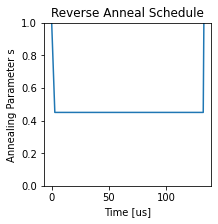

In [73]:
make_anneal_plot(reverse_schedule)

In [74]:
# Assign best Sampleset
best_sampleset = sampleset_quench3

In [75]:

i5 = int(5.0/95*len(best_sampleset))  # Index i5 is about a 5% indexial move from the sample of lowest energy

initial = dict(zip(best_sampleset.variables, best_sampleset.record[i5].sample))
reverse_anneal_params = dict(anneal_schedule=reverse_schedule, initial_state=initial, reinitialize_state=False)

# The `reinitialize_state` parameter switches between two qualitatively different methods of local search 
# via quantum annealing.  With `reinitialize_state = 'True'`, many anneals are seeded from the single starting 
# state and the states returned, modulo time-dependent sources of error, are independently and identically 
# distributed.  With `reinitialize_state = 'False'`, the series of anneals behaves like a random walk and 
# is capable of exploring the solution space more broadly.  


In [76]:
sampleset_reverse1 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr,
                                                                   **reverse_anneal_params)  


In [77]:
analyze(sampleset_reverse1, "reverse_schedule1", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [1.0099999999999998]
Average energy is 37.54 with standard deviation 20.62


In [78]:
sampleset_reverse2 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr,
                                                                   **reverse_anneal_params)  


In [79]:
analyze(sampleset_reverse2, "reverse_schedule2", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [1.6349999999999998]
Average energy is 44.82 with standard deviation 23.82


#### Make table of solutions:

In [80]:
df = pd.DataFrame(data, columns=["Label", "Best Known Solutions (%)", "Good Known Solutions (%)", "Lowest Energy", "Average Energy", "Standard Deviation"])
data

[['embedding1A', 0.2, 0.2, 9.065, 58.35253, 22.88197358072725],
 ['embedding1B',
  0.2,
  0.2,
  4.425000000000001,
  55.86147999999999,
  22.646244485777327],
 ['embedding2A', 0.2, 0.2, 5.365, 94.13476000000001, 36.45938338401241],
 ['embedding2B', 0.2, 0.2, 6.76, 83.82194, 38.140909304005845],
 ['embedding3A', 0.2, 0.6, -5.7, 18.45643, 14.687203610800116],
 ['embedding3B', 0.2, 1.0, -4.935, 18.62327, 14.295999816630525],
 ['default_chains',
  0.2,
  0.4,
  -6.504999999999999,
  15.483150000000002,
  13.528243552933988],
 ['scaled_chains1', 0.2, 0.2, 314.45, 647.86738, 147.81687740253344],
 ['scaled_chains2', 0.2, 0.2, 180.535, 618.38046, 153.6667707501801],
 ['torque_chains1',
  0.2,
  0.4,
  2.7750000000000004,
  48.24822,
  27.712629469821156],
 ['torque_chains2', 0.2, 0.2, -4.54, 50.73607, 28.547657788426356],
 ['time_20', 0.4, 0.6, 1.6000000000000005, 43.07133, 22.57713391423057],
 ['time_25',
  0.2,
  0.4,
  3.1350000000000007,
  47.082649999999994,
  25.141083409978574],
 ['tim

In [81]:
df

,Label,Best Known Solutions (%),Good Known Solutions (%),Lowest Energy,Average Energy,Standard Deviation
0,embedding1A,0.2,0.2,9.065,58.35253,22.881974
1,embedding1B,0.2,0.2,4.425,55.86148,22.646244
2,embedding2A,0.2,0.2,5.365,94.13476,36.459383
3,embedding2B,0.2,0.2,6.760,83.82194,38.140909
4,embedding3A,0.2,0.6,-5.700,18.45643,14.687204
5,embedding3B,0.2,1.0,-4.935,18.62327,14.296000
6,default_chains,0.2,0.4,-6.505,15.48315,13.528244
7,scaled_chains1,0.2,0.2,314.450,647.86738,147.816877
8,scaled_chains2,0.2,0.2,180.535,618.38046,153.666771
9,torque_chains1,0.2,0.4,2.775,48.24822,27.712629
